# 表情分析

Epoch 1/5 - train:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 1/5 - val  :   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1: train_acc=0.9889 val_acc=0.9967


Epoch 2/5 - train:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 2/5 - val  :   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2: train_acc=0.9988 val_acc=0.9976


Epoch 3/5 - train:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 3/5 - val  :   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3: train_acc=0.9991 val_acc=0.9958


Epoch 4/5 - train:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 4/5 - val  :   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4: train_acc=0.9988 val_acc=0.9972


Epoch 5/5 - train:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 5/5 - val  :   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5: train_acc=0.9998 val_acc=0.9972

 Best validation accuracy: 0.9976

Classification report:
              precision    recall  f1-score   support

         Sad     1.0000    0.9949    0.9975       989
       Happy     0.9956    1.0000    0.9978      1130

    accuracy                         0.9976      2119
   macro avg     0.9978    0.9975    0.9976      2119
weighted avg     0.9977    0.9976    0.9976      2119



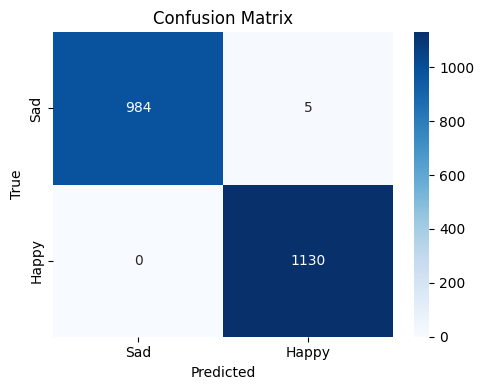

In [12]:
import os, copy, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

data_dir      = "emo"
batch_size    = 32
img_size      = 224
num_epochs    = 5
lr            = 1e-4
train_ratio   = 0.8
seed          = 42
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize(int(img_size*1.1)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_tf)
orig_classes = full_dataset.classes
full_dataset.targets = [1 if orig_classes[t].lower().startswith('happy') else 0 for t in full_dataset.targets]
class_names  = ["Sad", "Happy"]
num_classes  = 2

n_train = int(len(full_dataset)*train_ratio)
n_val   = len(full_dataset) - n_train
train_ds, val_ds = random_split(
    full_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(seed)
)

train_ds.dataset.transform = train_tf
val_ds.dataset.transform   = val_tf

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
best_acc  = 0
best_wts  = copy.deepcopy(model.state_dict())

for epoch in range(1, num_epochs+1):
    model.train()
    train_loss, train_correct = 0.0, 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - train"):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*x.size(0)
        train_correct += (out.argmax(1)==y).sum().item()

    model.eval()
    val_loss, val_correct = 0.0, 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} - val  "):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()*x.size(0)
            val_correct += (out.argmax(1)==y).sum().item()
            preds_all.append(out.argmax(1).cpu())
            labels_all.append(y.cpu())
    val_acc  = val_correct / len(val_ds)
    train_acc= train_correct / len(train_ds)
    print(f"Epoch {epoch}: train_acc={train_acc:.4f} val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_wts = copy.deepcopy(model.state_dict())

torch.save(best_wts, "best_happy_sad_resnet18.pth")
print(f"\n Best validation accuracy: {best_acc:.4f}")

model.load_state_dict(best_wts)
model.eval()
preds_all, labels_all = [], []
with torch.no_grad():
    for x, y in val_loader:
        preds_all.append(model(x.to(device)).argmax(1).cpu())
        labels_all.append(y)
preds_all   = torch.cat(preds_all).numpy()
labels_all  = torch.cat(labels_all).numpy()

print("\nClassification report:")
print(classification_report(labels_all, preds_all, target_names=class_names, digits=4))

cm = confusion_matrix(labels_all, preds_all)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()


# 語意分析

Count of class: 
sentiment
Happy    29617
Sad       2533
Name: count, dtype: int64
Count of class:  Counter({' Happy': 29617, ' Sad': 2533}) 

After RandomOverSampler:  Counter({1: 29617, 0: 29617}) 

=== Classification report ===
              precision    recall  f1-score   support

           0     0.9746    0.9993    0.9868      5924
           1     0.9993    0.9740    0.9865      5923

    accuracy                         0.9867     11847
   macro avg     0.9870    0.9867    0.9867     11847
weighted avg     0.9870    0.9867    0.9867     11847



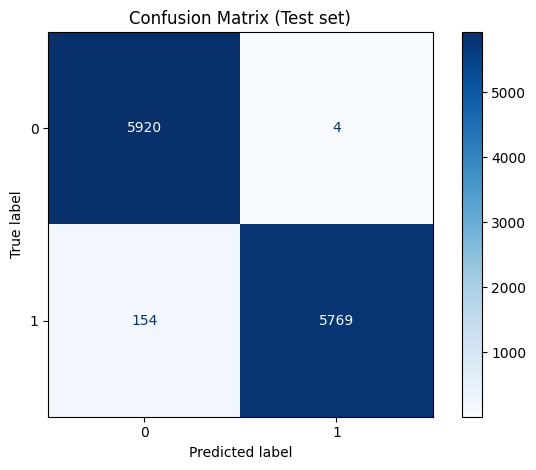

In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

df = pd.read_csv("topical_chat.csv").drop(columns="conversation_id", axis=1)
sent_clean = df["sentiment"].astype(str).str.strip().str.lower()
targets = ["sad", "sadness", "happy", "happiness"]
sad_happy_df = df[sent_clean.isin(targets)].reset_index(drop=True)

print("Count of class: ")
print(sad_happy_df["sentiment"].value_counts())

output_file = "sad_happy_subset.csv"
sad_happy_df.to_csv(output_file, index=False)

df = pd.read_csv("sad_happy_subset.csv")

print("Count of class: ", Counter(df["sentiment"]), "\n")

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(sad_happy_df[["message"]], sad_happy_df["sentiment"])
df_ros = pd.concat([X_res, y_res], axis=1)

df_ros["sentiment"] = (
    df_ros["sentiment"]
    .str.strip()
    .str.lower()
    .replace({"happiness": "happy", "sadness": "sad"})
    .map({"happy": 1, "sad": 0})
    .astype(int)
)

print("After RandomOverSampler: ", Counter(df_ros["sentiment"]), "\n")

X_train, X_test, y_train, y_test = train_test_split(
    df_ros["message"],
    df_ros["sentiment"],
    test_size=0.2,
    stratify=df_ros["sentiment"],
    random_state=42
)

pipe = make_pipeline(
    TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    ),
    LinearSVC()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("=== Classification report ===")
print(classification_report(y_test, y_pred, digits=4))

classes = np.unique(np.concatenate([y_test, y_pred]))
cm = confusion_matrix(y_test, y_pred, labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test set)")
plt.tight_layout()
plt.show()
